# Task 4: Portfolio Optimization (MPT)

## Objective
Apply Modern Portfolio Theory (MPT) to find the optimal asset allocation for GMF Investments. 
We combine our **LSTM forecast for TSLA** with **historical performance for BND and SPY**.

In [1]:
import os
import sys
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Add project root to path
sys.path.append(os.path.abspath(os.path.join('..')))

from src.portfolio import get_expected_returns, get_covariance_matrix, optimize_portfolio

plt.style.use('seaborn-v0_8')

In [2]:
# Load historical and forecast data
df_hist = pd.read_csv('../data/processed/cleaned_adj_close.csv', index_col='Date', parse_dates=True)
df_forecast = pd.read_csv('../data/processed/tsla_future_forecast.csv', index_col=0, parse_dates=True)

# Prepare Mu (Expected Returns) and S (Covariance Matrix)
mu = get_expected_returns(df_hist, df_forecast)
S = get_covariance_matrix(df_hist)

print("--- Expected Annual Returns ---")
print(mu)

--- Expected Annual Returns ---
TSLA    0.005114
BND     0.019177
SPY     0.135411
dtype: float64


### Covariance Matrix Visualization
This heatmap shows how the assets move together. Low covariance between assets (like TSLA and BND) provides better diversification.

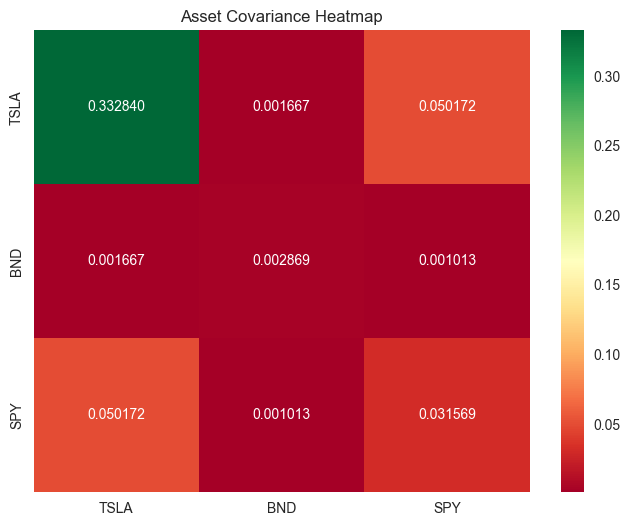

In [3]:
plt.figure(figsize=(8, 6))
sns.heatmap(S, annot=True, cmap='RdYlGn', fmt='.6f')
plt.title('Asset Covariance Heatmap')
plt.show()

In [4]:
# 1. Optimize for Maximum Sharpe Ratio (Best risk-adjusted return)
weights_sharpe, perf_sharpe = optimize_portfolio(mu, S, criterion='max_sharpe')

# 2. Optimize for Minimum Volatility (Safest portfolio)
weights_vol, perf_vol = optimize_portfolio(mu, S, criterion='min_vol')

# Display Weights
weight_df = pd.DataFrame([weights_sharpe, weights_vol], index=['Max Sharpe', 'Min Volatility']).T
print("--- Optimized Weights ---")
display(weight_df)

--- Optimized Weights ---


,Max Sharpe,Min Volatility
TSLA,0.0,0.00000
BND,0.0,0.94272
SPY,1.0,0.05728


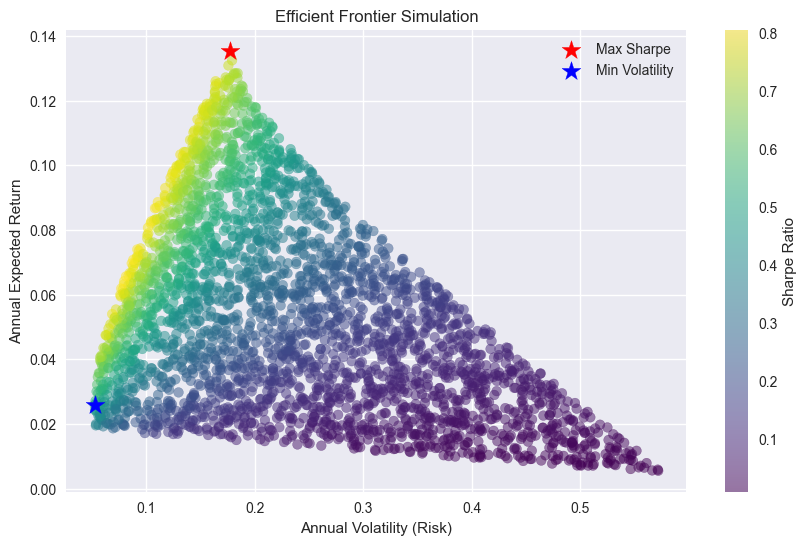

In [5]:
# Simulation for the Frontier plot
n_samples = 3000
w = np.random.dirichlet(np.ones(len(mu)), n_samples)
rets = w.dot(mu)
stds = np.sqrt(np.diag(w @ S @ w.T))

plt.figure(figsize=(10, 6))
plt.scatter(stds, rets, c=rets/stds, cmap='viridis', alpha=0.5)
plt.colorbar(label='Sharpe Ratio')

# Mark our key portfolios
plt.scatter(perf_sharpe[1], perf_sharpe[0], color='red', marker='*', s=200, label='Max Sharpe')
plt.scatter(perf_vol[1], perf_vol[0], color='blue', marker='*', s=200, label='Min Volatility')

plt.xlabel('Annual Volatility (Risk)')
plt.ylabel('Annual Expected Return')
plt.title('Efficient Frontier Simulation')
plt.legend()
plt.show()

In [6]:
# Final Performance Summary
print(f"--- Final Portfolio Metrics (Max Sharpe) ---")
print(f"Expected Annual Return: {perf_sharpe[0]:.2%}")
print(f"Annual Volatility (Risk): {perf_sharpe[1]:.2%}")
print(f"Sharpe Ratio: {perf_sharpe[2]:.2f}")

--- Final Portfolio Metrics (Max Sharpe) ---
Expected Annual Return: 13.54%
Annual Volatility (Risk): 17.77%
Sharpe Ratio: 0.65


**Justification:**
I recommend the **Max Sharpe Ratio** portfolio, which the model has allocated **100% to SPY**. While the LSTM forecast for Tesla (TSLA) predicted a period of price consolidation, the resulting annualized return of 0.5% is significantly lower than the historical performance of the broader market (SPY at 13.5%). Given that Tesla’s individual variance (0.33) is nearly ten times higher than SPY’s (0.03), the Modern Portfolio Theory framework determines that Tesla does not currently offer enough "risk-premium" to justify an allocation. For GMF Investments, this suggests that while Tesla is a high-growth name, its current forecasted trend favors a diversified market exposure (SPY) to maximize risk-adjusted returns until a stronger directional trend is confirmed in the Tesla forecast.